[tensor(5.6887), tensor(3.8709), tensor(8.2887), tensor(3.4577), tensor(3.2402), tensor(4.2094), tensor(9.3640), tensor(4.5493), tensor(3.6753), tensor(7.4958), tensor(4.4362), tensor(3.6653), tensor(5.0407), tensor(4.1607), tensor(4.0133), tensor(5.4690), tensor(3.4579), tensor(4.3558), tensor(12.5317), tensor(7.3944), tensor(4.9683), tensor(4.1077), tensor(-2.8826), tensor(2.4679), tensor(8.7158), tensor(5.5844), tensor(6.3157), tensor(4.9109), tensor(4.0527), tensor(4.9249), tensor(4.1243), tensor(3.1873), tensor(3.6325), tensor(5.7898), tensor(4.3374), tensor(4.4134), tensor(3.9700), tensor(5.0561), tensor(5.4618), tensor(3.7995), tensor(2.6572), tensor(5.2714), tensor(1.6367), tensor(2.2350), tensor(0.3866), tensor(8.7246), tensor(3.6449), tensor(3.8202), tensor(4.4491), tensor(7.3479), tensor(5.2542), tensor(4.3766), tensor(2.2654), tensor(-0.6813), tensor(4.3614), tensor(5.2052), tensor(1.2884), tensor(5.3898), tensor(4.6965), tensor(3.0395), tensor(4.7798), tensor(4.6280), tens

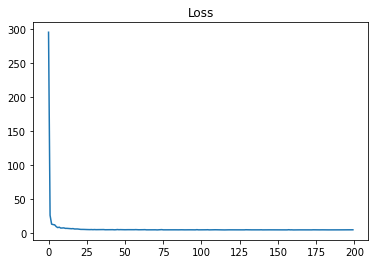

In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from matplotlib import pyplot as plt
from made import MADE

random.seed(234) # 123
torch.manual_seed(234)

# NN used for p(x | y)
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)
        
class simpleRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=32, max_l=5, max_t=3):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size + max_l + max_t, hidden_size=hidden_size, nonlinearity='relu',
                          batch_first=True, num_layers=1)
        self.h_0 = nn.Parameter(torch.zeros((1, 1, hidden_size)))
        self.out_loc = nn.Linear(hidden_size, 1)
        self.out_std = nn.Linear(hidden_size, 1)
        self.max_l = max_l # max time steps
        self.max_t = max_t # type of random variables, ex. y1 y2 next_x
        self.softplus = nn.Softplus()
        
    def forward(self, x, obs, l, t):
        """
        x: x0
        obs: R
        l: length
        t: type, y1, y2 or next_x
        """
        length = l * 3
        input_x = x.repeat((int(length), 1))
        input_obs = obs.repeat((int(length), 1))
        input_l = []
        input_t = []
        
        for n in range(int(l)):
            
            for i in range(int(t)):
                input_l.append(n)
                input_t.append(i)
        input_l = F.one_hot(torch.tensor(input_l), self.max_l) 
        input_t = F.one_hot(torch.tensor(input_t), self.max_t) 
        
        input_ = torch.unsqueeze(torch.cat([input_x, input_obs, input_l, input_t], -1), 0)
        
        # the input is [x, obs, onehot(l), onehot(t)]
        rnn_output, _ = self.rnn(input_, self.h_0)
        rnn_output = torch.squeeze(rnn_output, 0)
        out_loc = self.out_loc(F.relu(rnn_output))
        out_std = self.softplus(self.out_std(F.relu(rnn_output)))
        # the first outputs are y_1_1, y_2_1, next_x_1; y_1_2, y_2_2, next_x_2
        return torch.squeeze(out_loc, 1), torch.squeeze(out_std, 1) # shape l * t

class Experiment(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 3
        self.max_rec = 5
        
        # for guide_0
        self.x_nn_0 = simpleNN(input_size=1, t="bern")
        self.y_nn_1_0 = simpleNN(input_size=1)
        self.y_nn_2_0 = simpleNN(input_size=1)
    
        # for guide_1
        self.x_nn_1 = simpleNN(input_size=1, t="bern")
        self.y_nn_1_1 = simpleNN(input_size=2)
        self.y_nn_2_1 = simpleNN(input_size=2)
    
    def g(self, x):
        return torch.tanh(x) 
    
    def model(self, obs):
        pyro.module("model", self)
        
        x = pyro.sample("x", dist.Bernoulli(0.5))
        
        if x > 0:
            y =  pyro.sample("y", dist.Normal(1.5, 1))
        else:
            y =  pyro.sample("y", dist.Normal(3, 1))
        
        sig = torch.tensor(0.1)
        
        pyro.sample("obs", dist.Normal(y, sig), obs=float(obs))
        

    # guide uses simple and individual NN for each random variable
    def guide_0(self, obs):
        pyro.module("model", self)
       
        x_prob = self.x_nn_0([obs])
        x = pyro.sample("x", dist.Bernoulli(x_prob))
        
        if x > 0:
            y_loc, y_std = self.y_nn_1_0([obs])
            y =  pyro.sample("y", dist.Normal(y_loc, y_std))
        else:
            y_loc, y_std = self.y_nn_2_0([obs])
            y =  pyro.sample("y", dist.Normal(y_loc, y_std))
    
    # guide uses simple and individual NN for each random variable
    def guide_1(self, obs):
        pyro.module("model", self)
       
        x_prob = self.x_nn_1([obs])
        x = pyro.sample("x", dist.Bernoulli(x_prob))
        
        if x > 0:
            #y_loc, y_std = self.y_nn_1_1([obs, x_prob])
            y_loc, y_std = self.y_nn_1_1([obs, x])
            y =  pyro.sample("y", dist.Normal(y_loc, y_std))
        else:
            #y_loc, y_std = self.y_nn_2_1([obs, x_prob])
            y_loc, y_std = self.y_nn_2_1([obs, x])
            y =  pyro.sample("y", dist.Normal(y_loc, y_std))
            
    
def generate_data():
    # the actual data generation has three latent variables (y_1, y_2, y_3)
    x_prob = max(min(random.random() + dist.Normal(0.2, 0.5).sample(), 0.9), 0.1)
    
    x = dist.Bernoulli(x_prob).sample()
    
    if x > 0:
        mean = random.random() * 3 + 2
        std = random.random() + 0.658
        y = dist.Normal(mean, std).sample()
        y = dist.Normal(y + random.random(), std*2).sample()
    else:
        mean = random.random() * 1 + 4
        std = random.random() + 0.152
        y = dist.Normal(mean, std).sample()
    return y
    
data = []
num_data = 200 # 100
for _ in range(num_data):
    data.append(generate_data())

print(data)
experiment = Experiment()
adam_params = {"lr": 0.001, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
guide = experiment.guide_0 # guide_1

svi = SVI(experiment.model, guide, optimizer, loss=Trace_ELBO())

n_steps = 200
log_interval = 10
# do gradient steps
loss = 0
loss_track = []
for step in range(1, n_steps + 1):
    imme_loss = 0
    
    for obs in data:
        imme_loss += svi.step(obs) / num_data
        
    loss_track.append(imme_loss)
    loss += imme_loss / log_interval
    
    if step % log_interval == 0:
        print("[Step {}/{}] Immediate Loss: {} Accumlated Loss: {}".format(step, n_steps, imme_loss, loss))
        loss = 0
    
plt.plot(loss_track)
plt.title("Loss")
plt.show()
    

results:

In [2]:
# guide_0
[Step 10/200] Immediate Loss: 8.481406583273783 Accumlated Loss: 138.92595821277888
[Step 20/200] Immediate Loss: 5.827122594807298 Accumlated Loss: 6.824616750597954
[Step 30/200] Immediate Loss: 5.479589960807936 Accumlated Loss: 6.122400292096194
[Step 40/200] Immediate Loss: 5.235114186722786 Accumlated Loss: 5.868071163090412
[Step 50/200] Immediate Loss: 5.230031159862411 Accumlated Loss: 5.398840152133023
[Step 60/200] Immediate Loss: 4.941381576012355 Accumlated Loss: 5.2451702640415165
[Step 70/200] Immediate Loss: 5.1643944143434055 Accumlated Loss: 5.1688680721505085
[Step 80/200] Immediate Loss: 4.977463321115354 Accumlated Loss: 5.088783462397755
[Step 90/200] Immediate Loss: 4.915429681032547 Accumlated Loss: 4.998852465530391
[Step 100/200] Immediate Loss: 4.889856382282449 Accumlated Loss: 4.930096195126055
[Step 110/200] Immediate Loss: 5.036540711353885 Accumlated Loss: 4.943592827759556
[Step 120/200] Immediate Loss: 5.039725264719089 Accumlated Loss: 4.930605179857425
[Step 130/200] Immediate Loss: 5.059065213970024 Accumlated Loss: 4.90860458523815
[Step 140/200] Immediate Loss: 4.940604259062165 Accumlated Loss: 4.980269359458469
[Step 150/200] Immediate Loss: 4.902322931521559 Accumlated Loss: 4.932228341744303
[Step 160/200] Immediate Loss: 5.1983008842096385 Accumlated Loss: 4.950344393348063
[Step 170/200] Immediate Loss: 4.806001321339315 Accumlated Loss: 4.889006002039204
[Step 180/200] Immediate Loss: 4.986952164080137 Accumlated Loss: 4.875345367057301
[Step 190/200] Immediate Loss: 4.8897376226142955 Accumlated Loss: 4.904684411775412
[Step 200/200] Immediate Loss: 5.004684399832466 Accumlated Loss: 4.949257210554612

SyntaxError: invalid syntax (<ipython-input-2-2b56b9eb846d>, line 2)

In [ ]:
# guide_1
[Step 10/200] Immediate Loss: 11.723265527635808 Accumlated Loss: 158.07744119115924
[Step 20/200] Immediate Loss: 7.0115033677220335 Accumlated Loss: 7.743059941321611
[Step 30/200] Immediate Loss: 5.568605363368985 Accumlated Loss: 6.196570287048817
[Step 40/200] Immediate Loss: 5.199520883075892 Accumlated Loss: 5.525774829182774
[Step 50/200] Immediate Loss: 5.025597251914441 Accumlated Loss: 5.208455127271823
[Step 60/200] Immediate Loss: 4.85863864256069 Accumlated Loss: 5.040611718276979
[Step 70/200] Immediate Loss: 5.104041776752566 Accumlated Loss: 4.983732196276776
[Step 80/200] Immediate Loss: 4.867030485807919 Accumlated Loss: 4.9212386325227575
[Step 90/200] Immediate Loss: 4.8761734484438755 Accumlated Loss: 4.913726011077641
[Step 100/200] Immediate Loss: 5.023541996709683 Accumlated Loss: 4.91273052565677
[Step 110/200] Immediate Loss: 4.940182206740063 Accumlated Loss: 4.902736147870894
[Step 120/200] Immediate Loss: 4.8979976212938245 Accumlated Loss: 4.907227212036015
[Step 130/200] Immediate Loss: 4.938307256418921 Accumlated Loss: 4.86265199468225
[Step 140/200] Immediate Loss: 4.856055798890488 Accumlated Loss: 4.916034141579493
[Step 150/200] Immediate Loss: 4.878045419446584 Accumlated Loss: 4.929280334066892
[Step 160/200] Immediate Loss: 5.044146585931762 Accumlated Loss: 4.917067585667423
[Step 170/200] Immediate Loss: 4.772590825204636 Accumlated Loss: 4.860669169802714
[Step 180/200] Immediate Loss: 4.928167786201757 Accumlated Loss: 4.872080631799747
[Step 190/200] Immediate Loss: 4.857129885650064 Accumlated Loss: 4.890450273939073
[Step 200/200] Immediate Loss: 4.896220705355964 Accumlated Loss: 4.882933780943065

In [ ]:
# 0
[Step 10/200] Immediate Loss: 6.329348330907526 Accumlated Loss: 83.74248697780818
[Step 20/200] Immediate Loss: 4.78288633824326 Accumlated Loss: 5.276437185511925
[Step 30/200] Immediate Loss: 4.7403195415437205 Accumlated Loss: 4.750574695361779
[Step 40/200] Immediate Loss: 4.638174880848966 Accumlated Loss: 4.5884155824468476
[Step 50/200] Immediate Loss: 4.653941555392811 Accumlated Loss: 4.513697536185791
[Step 60/200] Immediate Loss: 4.627054877117982 Accumlated Loss: 4.530043110702847
[Step 70/200] Immediate Loss: 4.464643498879968 Accumlated Loss: 4.474516210590077
[Step 80/200] Immediate Loss: 4.439730934067952 Accumlated Loss: 4.488008958363516
[Step 90/200] Immediate Loss: 4.53654706622618 Accumlated Loss: 4.456650750458131
[Step 100/200] Immediate Loss: 4.400493721984981 Accumlated Loss: 4.430780795232551
[Step 110/200] Immediate Loss: 4.509002554508242 Accumlated Loss: 4.475029762922149
[Step 120/200] Immediate Loss: 4.413638624070391 Accumlated Loss: 4.438440319239027
[Step 130/200] Immediate Loss: 4.5498218181579 Accumlated Loss: 4.471651754439898
[Step 140/200] Immediate Loss: 4.373417100855421 Accumlated Loss: 4.428907605508969
[Step 150/200] Immediate Loss: 4.549445116027336 Accumlated Loss: 4.432188125092466
[Step 160/200] Immediate Loss: 4.544727864170218 Accumlated Loss: 4.443647913407853
[Step 170/200] Immediate Loss: 4.4030221931870255 Accumlated Loss: 4.408120165453587
[Step 180/200] Immediate Loss: 4.396375845459053 Accumlated Loss: 4.432364422364805
[Step 190/200] Immediate Loss: 4.432063233334848 Accumlated Loss: 4.40650718549003
[Step 200/200] Immediate Loss: 4.410849580574181 Accumlated Loss: 4.397266691096533

In [ ]:
0: 64 dim
[Step 10/200] Immediate Loss: 4.892548137257108 Accumlated Loss: 25.175123196755194
[Step 20/200] Immediate Loss: 4.758278623902004 Accumlated Loss: 4.710510768516105
[Step 30/200] Immediate Loss: 4.588608430172572 Accumlated Loss: 4.763768781696699
[Step 40/200] Immediate Loss: 4.675227941598608 Accumlated Loss: 4.660967427416472
[Step 50/200] Immediate Loss: 4.5980175924641795 Accumlated Loss: 4.690014428250329
[Step 60/200] Immediate Loss: 4.452137063505405 Accumlated Loss: 4.668534330072428
[Step 70/200] Immediate Loss: 4.677649372447063 Accumlated Loss: 4.598335882357667
[Step 80/200] Immediate Loss: 4.690546879154372 Accumlated Loss: 4.568423189383524
[Step 90/200] Immediate Loss: 4.502625433626427 Accumlated Loss: 4.535526312640294
[Step 100/200] Immediate Loss: 4.507959322865512 Accumlated Loss: 4.539393051659962
[Step 110/200] Immediate Loss: 4.577937096728701 Accumlated Loss: 4.536217603941878
[Step 120/200] Immediate Loss: 4.557467424991199 Accumlated Loss: 4.539361650452866
[Step 130/200] Immediate Loss: 4.543855754571498 Accumlated Loss: 4.523867381748434
[Step 140/200] Immediate Loss: 4.601759381196598 Accumlated Loss: 4.540427309621547
[Step 150/200] Immediate Loss: 4.455749744192999 Accumlated Loss: 4.497635044049465
[Step 160/200] Immediate Loss: 4.559713857203792 Accumlated Loss: 4.515638842284788
[Step 170/200] Immediate Loss: 4.506635000804083 Accumlated Loss: 4.523887936461107
[Step 180/200] Immediate Loss: 4.531122605114395 Accumlated Loss: 4.502436893166829
[Step 190/200] Immediate Loss: 4.4107590396855745 Accumlated Loss: 4.458605431016796
[Step 200/200] Immediate Loss: 4.406933291976797 Accumlated Loss: 4.473983885180661

In [ ]:
# 1 
[Step 10/200] Immediate Loss: 8.99335336676194 Accumlated Loss: 93.11557751736001
[Step 20/200] Immediate Loss: 7.757730990499698 Accumlated Loss: 8.150530896322358
[Step 30/200] Immediate Loss: 7.251889504697169 Accumlated Loss: 7.62071710877218
[Step 40/200] Immediate Loss: 4.677049168914674 Accumlated Loss: 4.972788094645658
[Step 50/200] Immediate Loss: 4.739154729392898 Accumlated Loss: 4.543627997050383
[Step 60/200] Immediate Loss: 4.645770498027884 Accumlated Loss: 4.506981913097405
[Step 70/200] Immediate Loss: 4.431528997150307 Accumlated Loss: 4.464423873282858
[Step 80/200] Immediate Loss: 4.463611593075621 Accumlated Loss: 4.45461358745756
[Step 90/200] Immediate Loss: 4.604924235458547 Accumlated Loss: 4.454517559632595
[Step 100/200] Immediate Loss: 4.401257157894304 Accumlated Loss: 4.4150539258585635
[Step 110/200] Immediate Loss: 4.469707039907149 Accumlated Loss: 4.439741982026343
[Step 120/200] Immediate Loss: 4.400099222563222 Accumlated Loss: 4.420476458520239
[Step 130/200] Immediate Loss: 4.4864507112593275 Accumlated Loss: 4.46372244460293
[Step 140/200] Immediate Loss: 4.3791043448489475 Accumlated Loss: 4.41920482103407
[Step 150/200] Immediate Loss: 4.513532081914066 Accumlated Loss: 4.425186696831541
[Step 160/200] Immediate Loss: 4.453900899845154 Accumlated Loss: 4.43659522759344
[Step 170/200] Immediate Loss: 4.3917057774518975 Accumlated Loss: 4.397434466401062
[Step 180/200] Immediate Loss: 4.405244329166033 Accumlated Loss: 4.426350365344331
[Step 190/200] Immediate Loss: 4.429013590349041 Accumlated Loss: 4.410054011311578
[Step 200/200] Immediate Loss: 4.415098900823153 Accumlated Loss: 4.394547299068895

In [ ]:
# 1 64
[Step 10/200] Immediate Loss: 4.945362403555771 Accumlated Loss: 27.69191990887678
[Step 20/200] Immediate Loss: 4.705575195045094 Accumlated Loss: 4.74906130639941
[Step 30/200] Immediate Loss: 4.698617646599962 Accumlated Loss: 4.640836778211009
[Step 40/200] Immediate Loss: 4.597827718715852 Accumlated Loss: 4.6130812472309035
[Step 50/200] Immediate Loss: 4.473430356117529 Accumlated Loss: 4.592548839382395
[Step 60/200] Immediate Loss: 4.46108817300642 Accumlated Loss: 4.592729462655066
[Step 70/200] Immediate Loss: 4.5765040191570705 Accumlated Loss: 4.541705991156426
[Step 80/200] Immediate Loss: 4.615994801401456 Accumlated Loss: 4.527830253832891
[Step 90/200] Immediate Loss: 4.481257107800941 Accumlated Loss: 4.490467119288146
[Step 100/200] Immediate Loss: 4.447113471263 Accumlated Loss: 4.491194007766871
[Step 110/200] Immediate Loss: 4.5426124627442945 Accumlated Loss: 4.519777140050051
[Step 120/200] Immediate Loss: 4.526237935109501 Accumlated Loss: 4.484898105297211
[Step 130/200] Immediate Loss: 4.473364450465856 Accumlated Loss: 4.533105885510274
[Step 140/200] Immediate Loss: 4.567623599485331 Accumlated Loss: 4.52751955585112
[Step 150/200] Immediate Loss: 4.41103993565831 Accumlated Loss: 4.478847055589327
[Step 160/200] Immediate Loss: 4.511077263662673 Accumlated Loss: 4.4720754014044966
[Step 170/200] Immediate Loss: 4.542323929173933 Accumlated Loss: 4.497481884213555
[Step 180/200] Immediate Loss: 4.50154203534666 Accumlated Loss: 4.473875064988429
[Step 190/200] Immediate Loss: 4.401739050099132 Accumlated Loss: 4.434624359889895
[Step 200/200] Immediate Loss: 4.387687901801735 Accumlated Loss: 4.44847219620134

In [ ]:
[Step 10/200] Immediate Loss: 8.831484226306204 Accumlated Loss: 92.57391344586635
[Step 20/200] Immediate Loss: 7.672439583418599 Accumlated Loss: 8.07972444701544
[Step 30/200] Immediate Loss: 7.132741034831854 Accumlated Loss: 7.55862317237309
[Step 40/200] Immediate Loss: 4.677748353678033 Accumlated Loss: 5.098062943419558
[Step 50/200] Immediate Loss: 4.679151139205498 Accumlated Loss: 4.543261697728505
[Step 60/200] Immediate Loss: 4.584433643865686 Accumlated Loss: 4.509522491115827
[Step 70/200] Immediate Loss: 4.435553869615634 Accumlated Loss: 4.472845446982376
[Step 80/200] Immediate Loss: 4.473667657795313 Accumlated Loss: 4.467331585498362
[Step 90/200] Immediate Loss: 4.57488175244379 Accumlated Loss: 4.451495232960025
[Step 100/200] Immediate Loss: 4.411818439136213 Accumlated Loss: 4.4210633398501855
[Step 110/200] Immediate Loss: 4.500276961633972 Accumlated Loss: 4.44278682423249
[Step 120/200] Immediate Loss: 4.4029467117227155 Accumlated Loss: 4.448023516570168
[Step 130/200] Immediate Loss: 4.477503563134409 Accumlated Loss: 4.449889423225052
[Step 140/200] Immediate Loss: 4.402364695998658 Accumlated Loss: 4.421440594784628
[Step 150/200] Immediate Loss: 4.511436905828703 Accumlated Loss: 4.419802880970236
[Step 160/200] Immediate Loss: 4.443736040807333 Accumlated Loss: 4.431105941411857
[Step 170/200] Immediate Loss: 4.383108533682583 Accumlated Loss: 4.39920712296829
[Step 180/200] Immediate Loss: 4.392443198401652 Accumlated Loss: 4.42824548353719
[Step 190/200] Immediate Loss: 4.442726319093451 Accumlated Loss: 4.4066880922388645
[Step 200/200] Immediate Loss: 4.410327961656151 Accumlated Loss: 4.390989160202206

In [ ]:
# 64
[Step 10/200] Immediate Loss: 5.0620588922360925 Accumlated Loss: 27.452954740482358
[Step 20/200] Immediate Loss: 4.713291444507197 Accumlated Loss: 4.788754089152151
[Step 30/200] Immediate Loss: 4.634649143260541 Accumlated Loss: 4.6462725308926816
[Step 40/200] Immediate Loss: 4.6207774791965495 Accumlated Loss: 4.6055218528176685
[Step 50/200] Immediate Loss: 4.4578128340049785 Accumlated Loss: 4.61917436520109
[Step 60/200] Immediate Loss: 4.447374501921998 Accumlated Loss: 4.622418769791898
[Step 70/200] Immediate Loss: 4.543967185654741 Accumlated Loss: 4.565392534922121
[Step 80/200] Immediate Loss: 4.578531220450167 Accumlated Loss: 4.524564780922472
[Step 90/200] Immediate Loss: 4.405554208563901 Accumlated Loss: 4.490992267451667
[Step 100/200] Immediate Loss: 4.446496614735619 Accumlated Loss: 4.496830442796352
[Step 110/200] Immediate Loss: 4.547037405858325 Accumlated Loss: 4.5112183366432035
[Step 120/200] Immediate Loss: 4.47335481010806 Accumlated Loss: 4.4820363790957485
[Step 130/200] Immediate Loss: 4.452953545151037 Accumlated Loss: 4.513302449157598
[Step 140/200] Immediate Loss: 4.53919651298199 Accumlated Loss: 4.512797385059419
[Step 150/200] Immediate Loss: 4.446720929628343 Accumlated Loss: 4.458740986451288
[Step 160/200] Immediate Loss: 4.5302174922797525 Accumlated Loss: 4.4738017470237015
[Step 170/200] Immediate Loss: 4.535937208600031 Accumlated Loss: 4.513784821757491
[Step 180/200] Immediate Loss: 4.49221648635508 Accumlated Loss: 4.468325105696669
[Step 190/200] Immediate Loss: 4.401864079190618 Accumlated Loss: 4.453588182533722
[Step 200/200] Immediate Loss: 4.396582488523782 Accumlated Loss: 4.45766376830176

In [ ]:
# 1
[Step 10/200] Immediate Loss: 11.867968449751281 Accumlated Loss: 119.53311509676469
[Step 20/200] Immediate Loss: 10.896902794421045 Accumlated Loss: 11.177019027288752
[Step 30/200] Immediate Loss: 11.021964176489833 Accumlated Loss: 10.94709603698649
[Step 40/200] Immediate Loss: 10.923975546091246 Accumlated Loss: 10.86278771985766
[Step 50/200] Immediate Loss: 6.540438774676149 Accumlated Loss: 8.422786458936722
[Step 60/200] Immediate Loss: 6.534668608381688 Accumlated Loss: 6.45782886935246
[Step 70/200] Immediate Loss: 6.3713626058081 Accumlated Loss: 6.385740896648528
[Step 80/200] Immediate Loss: 6.418236161129959 Accumlated Loss: 6.424380043813726
[Step 90/200] Immediate Loss: 6.467850190901271 Accumlated Loss: 6.353147416662856
[Step 100/200] Immediate Loss: 6.402001483161336 Accumlated Loss: 6.354380667378639
[Step 110/200] Immediate Loss: 6.406023255667608 Accumlated Loss: 6.361599933337801
[Step 120/200] Immediate Loss: 6.331160633069068 Accumlated Loss: 6.354397479556364
[Step 130/200] Immediate Loss: 6.428838450391046 Accumlated Loss: 6.364616919689946
[Step 140/200] Immediate Loss: 6.281965446018525 Accumlated Loss: 6.350332170550652
[Step 150/200] Immediate Loss: 6.487718800097312 Accumlated Loss: 6.357617957601458
[Step 160/200] Immediate Loss: 6.420994718482842 Accumlated Loss: 6.356143715201076
[Step 170/200] Immediate Loss: 6.366521451198219 Accumlated Loss: 6.355294009417903
[Step 180/200] Immediate Loss: 6.330180337278418 Accumlated Loss: 6.355438968158276
[Step 190/200] Immediate Loss: 6.351852865357609 Accumlated Loss: 6.327770651926091
[Step 200/200] Immediate Loss: 6.335215225769062 Accumlated Loss: 6.30661983309009

In [ ]:
# 0 
[Step 10/200] Immediate Loss: 9.346970654129983 Accumlated Loss: 113.1739841233491
[Step 20/200] Immediate Loss: 6.975127419019119 Accumlated Loss: 7.69983969870489
[Step 30/200] Immediate Loss: 6.743622715440579 Accumlated Loss: 6.692427675213664
[Step 40/200] Immediate Loss: 6.436417305622891 Accumlated Loss: 6.471210175176849
[Step 50/200] Immediate Loss: 6.713871218829665 Accumlated Loss: 6.458653660540082
[Step 60/200] Immediate Loss: 6.484426397361198 Accumlated Loss: 6.472620006053537
[Step 70/200] Immediate Loss: 6.405989019334527 Accumlated Loss: 6.412187910313097
[Step 80/200] Immediate Loss: 6.362180096338657 Accumlated Loss: 6.401051664661315
[Step 90/200] Immediate Loss: 6.4202219687911635 Accumlated Loss: 6.375913588481626
[Step 100/200] Immediate Loss: 6.364927740305324 Accumlated Loss: 6.360376990470423
[Step 110/200] Immediate Loss: 6.421359613376986 Accumlated Loss: 6.377258479340531
[Step 120/200] Immediate Loss: 6.318274569223457 Accumlated Loss: 6.363953679904944
[Step 130/200] Immediate Loss: 6.438532743051219 Accumlated Loss: 6.370663608934299
[Step 140/200] Immediate Loss: 6.2974191956826395 Accumlated Loss: 6.370326233826152
[Step 150/200] Immediate Loss: 6.5141160295399185 Accumlated Loss: 6.3641636528517935
[Step 160/200] Immediate Loss: 6.415865887324406 Accumlated Loss: 6.362849791377189
[Step 170/200] Immediate Loss: 6.376131625174 Accumlated Loss: 6.371652579213016
[Step 180/200] Immediate Loss: 6.3248094469067215 Accumlated Loss: 6.36185570209
[Step 190/200] Immediate Loss: 6.433083155437597 Accumlated Loss: 6.338922789049341
[Step 200/200] Immediate Loss: 6.318668476126111 Accumlated Loss: 6.312395074093867

In [ ]:
[Step 10/200] Immediate Loss: 11.976727526047911 Accumlated Loss: 119.53362743361764
[Step 20/200] Immediate Loss: 10.916181364493935 Accumlated Loss: 11.219259248388454
[Step 30/200] Immediate Loss: 11.043343579947303 Accumlated Loss: 10.973555087051766
[Step 40/200] Immediate Loss: 10.943668668569366 Accumlated Loss: 10.884751558892942
[Step 50/200] Immediate Loss: 6.559941983489846 Accumlated Loss: 8.770927740397756
[Step 60/200] Immediate Loss: 6.5468337412347655 Accumlated Loss: 6.469271936579125
[Step 70/200] Immediate Loss: 6.375677891010669 Accumlated Loss: 6.388119940882053
[Step 80/200] Immediate Loss: 6.4188883962476675 Accumlated Loss: 6.392748077415217
[Step 90/200] Immediate Loss: 6.455901776794543 Accumlated Loss: 6.356703812085604
[Step 100/200] Immediate Loss: 6.369250865431012 Accumlated Loss: 6.352617141379314
[Step 110/200] Immediate Loss: 6.420737668370759 Accumlated Loss: 6.367711289280597
[Step 120/200] Immediate Loss: 6.352763859998925 Accumlated Loss: 6.354864450324396
[Step 130/200] Immediate Loss: 6.516434524765906 Accumlated Loss: 6.371440517413238
[Step 140/200] Immediate Loss: 6.317252023398081 Accumlated Loss: 6.360252985506631
[Step 150/200] Immediate Loss: 6.513535037960472 Accumlated Loss: 6.360937603042849
[Step 160/200] Immediate Loss: 6.415885079816072 Accumlated Loss: 6.360746409138264
[Step 170/200] Immediate Loss: 6.36712605305134 Accumlated Loss: 6.351436705747479
[Step 180/200] Immediate Loss: 6.3286450622526305 Accumlated Loss: 6.354895116672755
[Step 190/200] Immediate Loss: 6.341010142530811 Accumlated Loss: 6.330026590914046
[Step 200/200] Immediate Loss: 6.329053945091422 Accumlated Loss: 6.301397666465279

In [ ]:
[Step 10/200] Immediate Loss: 21.522718148746375 Accumlated Loss: 207.41512029347075
[Step 20/200] Immediate Loss: 21.41585597807821 Accumlated Loss: 21.62552405459855
[Step 30/200] Immediate Loss: 21.38234384285553 Accumlated Loss: 21.344668118501385
[Step 40/200] Immediate Loss: 21.313893368692646 Accumlated Loss: 21.253254188452377
[Step 50/200] Immediate Loss: 21.363491764812153 Accumlated Loss: 21.303800385953817
[Step 60/200] Immediate Loss: 21.306386903702688 Accumlated Loss: 21.349030146154583
[Step 70/200] Immediate Loss: 21.3736292214927 Accumlated Loss: 21.306491545348806
[Step 80/200] Immediate Loss: 21.421294747908846 Accumlated Loss: 21.33118316067945
[Step 90/200] Immediate Loss: 13.87480960085825 Accumlated Loss: 17.12417806620567
[Step 100/200] Immediate Loss: 13.927702356373555 Accumlated Loss: 13.906270983097054
[Step 110/200] Immediate Loss: 14.007013700691347 Accumlated Loss: 13.887582020328281
[Step 120/200] Immediate Loss: 13.89133027452584 Accumlated Loss: 13.894257074591739
[Step 130/200] Immediate Loss: 13.889141324461221 Accumlated Loss: 13.89091330057241
[Step 140/200] Immediate Loss: 13.84332546837301 Accumlated Loss: 13.889453015338978
[Step 150/200] Immediate Loss: 13.888112702304891 Accumlated Loss: 13.878427546747785
[Step 160/200] Immediate Loss: 13.94087721885077 Accumlated Loss: 13.909350519925027
[Step 170/200] Immediate Loss: 13.962335496115275 Accumlated Loss: 13.914065014255666
[Step 180/200] Immediate Loss: 14.022486991893508 Accumlated Loss: 13.890356543407954
[Step 190/200] Immediate Loss: 13.875961518199109 Accumlated Loss: 13.86669538253719
[Step 200/200] Immediate Loss: 13.785965126088437 Accumlated Loss: 13.827820913653575

In [ ]:
[Step 10/200] Immediate Loss: 21.536989645789088 Accumlated Loss: 207.38362745398382
[Step 20/200] Immediate Loss: 21.431367387868757 Accumlated Loss: 21.642072230243198
[Step 30/200] Immediate Loss: 21.396480620934998 Accumlated Loss: 21.355699536390183
[Step 40/200] Immediate Loss: 21.317475201955222 Accumlated Loss: 21.257319459231077
[Step 50/200] Immediate Loss: 21.388170568096967 Accumlated Loss: 21.30689317368248
[Step 60/200] Immediate Loss: 21.29509833189178 Accumlated Loss: 21.37378634752352
[Step 70/200] Immediate Loss: 21.39207734857011 Accumlated Loss: 21.309895196958443
[Step 80/200] Immediate Loss: 21.41701041480391 Accumlated Loss: 21.34648537312752
[Step 90/200] Immediate Loss: 13.900549236834985 Accumlated Loss: 18.788400901073675
[Step 100/200] Immediate Loss: 13.946606806151816 Accumlated Loss: 13.927764978277349
[Step 110/200] Immediate Loss: 13.93928362660724 Accumlated Loss: 13.86846119425471
[Step 120/200] Immediate Loss: 13.879952646393416 Accumlated Loss: 13.887025538922336
[Step 130/200] Immediate Loss: 13.859915165703011 Accumlated Loss: 13.89090403190948
[Step 140/200] Immediate Loss: 13.843595463325856 Accumlated Loss: 13.907684028480258
[Step 150/200] Immediate Loss: 13.987846254238427 Accumlated Loss: 13.876980365017154
[Step 160/200] Immediate Loss: 13.942431985275736 Accumlated Loss: 13.889264042637969
[Step 170/200] Immediate Loss: 13.959955432193178 Accumlated Loss: 13.911328180621643
[Step 180/200] Immediate Loss: 13.879409624821916 Accumlated Loss: 13.861598426539615
[Step 190/200] Immediate Loss: 13.820956494832117 Accumlated Loss: 13.851386304608157
[Step 200/200] Immediate Loss: 13.781572264708917 Accumlated Loss: 13.902101758820784

In [ ]:
[Step 10/200] Immediate Loss: 19.228435556888595 Accumlated Loss: 200.26897022835902
[Step 20/200] Immediate Loss: 14.617401484767901 Accumlated Loss: 16.215209771615914
[Step 30/200] Immediate Loss: 14.258991522621649 Accumlated Loss: 14.351622893503107
[Step 40/200] Immediate Loss: 13.953358450610619 Accumlated Loss: 13.975740830798694
[Step 50/200] Immediate Loss: 13.966162201228464 Accumlated Loss: 13.958601482277473
[Step 60/200] Immediate Loss: 13.895017380411408 Accumlated Loss: 14.04609221756147
[Step 70/200] Immediate Loss: 14.049807088218627 Accumlated Loss: 14.019568621321302
[Step 80/200] Immediate Loss: 13.96307481053616 Accumlated Loss: 13.975776579574655
[Step 90/200] Immediate Loss: 13.941820238092808 Accumlated Loss: 13.92562076001628
[Step 100/200] Immediate Loss: 13.981783624634213 Accumlated Loss: 13.921046124255986
[Step 110/200] Immediate Loss: 13.985471663292016 Accumlated Loss: 13.920347134704944
[Step 120/200] Immediate Loss: 13.892946001580935 Accumlated Loss: 13.91870265561967
[Step 130/200] Immediate Loss: 13.866418977553318 Accumlated Loss: 14.143524776566458
[Step 140/200] Immediate Loss: 13.881403735286325 Accumlated Loss: 13.907811260371544
[Step 150/200] Immediate Loss: 13.889705268616018 Accumlated Loss: 13.897106436001556
[Step 160/200] Immediate Loss: 13.98417887743753 Accumlated Loss: 13.92414206849322
[Step 170/200] Immediate Loss: 13.977509658064132 Accumlated Loss: 13.913636127557293
[Step 180/200] Immediate Loss: 14.01252704814085 Accumlated Loss: 13.928915505240232
[Step 190/200] Immediate Loss: 13.868995597070706 Accumlated Loss: 13.867599604848294
[Step 200/200] Immediate Loss: 13.802424267921582 Accumlated Loss: 13.839087068237767

In [ ]:
# 0 234
[Step 10/200] Immediate Loss: 7.195491719357669 Accumlated Loss: 39.700878605598575
[Step 20/200] Immediate Loss: 5.6998961744457475 Accumlated Loss: 6.26671837088093
[Step 30/200] Immediate Loss: 4.692294080862777 Accumlated Loss: 4.946705584792887
[Step 40/200] Immediate Loss: 4.796591249112097 Accumlated Loss: 4.752417349870171
[Step 50/200] Immediate Loss: 4.621495101320762 Accumlated Loss: 4.670041528392663
[Step 60/200] Immediate Loss: 4.534939376313593 Accumlated Loss: 4.618246412111732
[Step 70/200] Immediate Loss: 4.585024912086808 Accumlated Loss: 4.551269153323987
[Step 80/200] Immediate Loss: 4.454118347572948 Accumlated Loss: 4.474291823778582
[Step 90/200] Immediate Loss: 4.4294447009708335 Accumlated Loss: 4.472697340578821
[Step 100/200] Immediate Loss: 4.429915012706409 Accumlated Loss: 4.477198233705097
[Step 110/200] Immediate Loss: 4.5613434716909556 Accumlated Loss: 4.455384294834135
[Step 120/200] Immediate Loss: 4.443874849736525 Accumlated Loss: 4.425778731042524
[Step 130/200] Immediate Loss: 4.571623991941054 Accumlated Loss: 4.450863315437208
[Step 140/200] Immediate Loss: 4.510091479033561 Accumlated Loss: 4.427214763087768
[Step 150/200] Immediate Loss: 4.523874952274341 Accumlated Loss: 4.427721300816889
[Step 160/200] Immediate Loss: 4.454986119801448 Accumlated Loss: 4.432565965245174
[Step 170/200] Immediate Loss: 4.372630771429708 Accumlated Loss: 4.390093631051786
[Step 180/200] Immediate Loss: 4.448110207207775 Accumlated Loss: 4.423109177469071
[Step 190/200] Immediate Loss: 4.415633551918446 Accumlated Loss: 4.4107278995792125
[Step 200/200] Immediate Loss: 4.496516553735528 Accumlated Loss: 4.427401870993286

In [ ]:
# 1 234
[Step 10/200] Immediate Loss: 5.163286211934024 Accumlated Loss: 89.67468019718086
[Step 20/200] Immediate Loss: 4.85941919376055 Accumlated Loss: 5.134031581087738
[Step 30/200] Immediate Loss: 4.585264132897757 Accumlated Loss: 4.708425559706526
[Step 40/200] Immediate Loss: 4.679668403368051 Accumlated Loss: 4.586337144322442
[Step 50/200] Immediate Loss: 4.5222279742961105 Accumlated Loss: 4.528223784671318
[Step 60/200] Immediate Loss: 4.481008359609841 Accumlated Loss: 4.513519197768703
[Step 70/200] Immediate Loss: 4.473330731441311 Accumlated Loss: 4.449387745317834
[Step 80/200] Immediate Loss: 4.449380338746997 Accumlated Loss: 4.430350501309596
[Step 90/200] Immediate Loss: 4.417518493975252 Accumlated Loss: 4.453708892139199
[Step 100/200] Immediate Loss: 4.413964221336027 Accumlated Loss: 4.450385621989551
[Step 110/200] Immediate Loss: 4.564237365521452 Accumlated Loss: 4.451846125569707
[Step 120/200] Immediate Loss: 4.442553746158893 Accumlated Loss: 4.424714446612678
[Step 130/200] Immediate Loss: 4.518962269911807 Accumlated Loss: 4.443732491511808
[Step 140/200] Immediate Loss: 4.545073836554788 Accumlated Loss: 4.440178459096454
[Step 150/200] Immediate Loss: 4.470176245754756 Accumlated Loss: 4.434489087089757
[Step 160/200] Immediate Loss: 4.422263964162077 Accumlated Loss: 4.40676958991898
[Step 170/200] Immediate Loss: 4.383147394212428 Accumlated Loss: 4.4095130517454315
[Step 180/200] Immediate Loss: 4.429771131227608 Accumlated Loss: 4.606229147210775
[Step 190/200] Immediate Loss: 4.3953610116103645 Accumlated Loss: 4.414204198712615
[Step 200/200] Immediate Loss: 4.4102370617644935 Accumlated Loss: 4.444824702411117